# Extracting events given location and wind thresholds

This code does stuff...

By Claire Krause, October 2017. Python v2. TCRM branch `develop` (but should be applicable to other branches).

**Required inputs**
- This code requires access to TCRM modules (e.g. `database`, `Utilities.`). Make sure the the TCRM directory is in the python path so these modules can be found and imported
- TCRM configuration file. This will tell the code where to look for the hazard and location databases.
- This code assumes that hazard and location databases have already been created. This code does not produce these databases.
- Dict of locations for which you would like to extract events that meet a given wind speed and distance threshold. This dict is defined within the code, and does not need to be imported.

## Set up the notebook imports

In [1]:
%pylab notebook
from __future__ import print_function, division

Populating the interactive namespace from numpy and matplotlib


In [23]:
import database
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm
from math import cos, asin, sqrt
import os
import pickle
#import cartopy.crs as ccrs
#import cartopy.feature as feature
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset

from Utilities.config import ConfigParser
from Utilities.lmomentFit import samlmu, pelgev, pelgpa
from Utilities.track import ncReadTrackData

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

In [3]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def loadTrack(trackId):
    trackNum, trackYear = int(trackId.split('-')[0]), int(trackId.split('-')[1])
    trackFile = os.path.join(outputPath, 'tracks', 'tracks.{0:05d}.nc'.format(trackYear))
    tracks = ncReadTrackData(trackFile)
    
    return [t for t in tracks if t.trackId==(trackNum, trackYear)][0]

def getTracks(recs):
    tracks = []
    for rec in recs:
        trackId = rec['eventId']
        track = loadTrack(trackId)
        tracks.append(track)
    return tracks

def plot_relevant_tracks(name_list, speed_thr, dist_thr):
    '''
    Plot tracks that have been identified as meeting a given distance and speed threshold.
    Function adapted after Craig Arthur's 'Extracting events from TCRM database' notebook.
    '''
    locLon = name_list[0][2]
    locLat = name_list[0][3]
    domain = config.geteval('Region', 'gridLimit')
    xx = np.arange(domain['xMin'], domain['xMax'] + 0.1, 0.1)
    yy = np.arange(domain['yMin'], domain['yMax'] + 0.1, 0.1)
    [xgrid, ygrid] = np.meshgrid(xx,yy)
    mapkwargs = dict(llcrnrlon=domain['xMin']-10,
                     llcrnrlat=domain['yMin'],
                     urcrnrlon=domain['xMax'],
                     urcrnrlat=domain['yMax'],
                     resolution='f',
                     projection='merc')
    mapobj = Basemap(ax=axes, **mapkwargs)
    mx, my = mapobj(xgrid, ygrid)
    xmin = mapobj.llcrnrlon
    xmax = mapobj.urcrnrlon
    ymin = mapobj.llcrnrlat
    ymax = mapobj.urcrnrlat

    dx = abs(xmin - xmax)
    dy = abs(ymin - ymax)
    dd = max(dx, dy)
    gr_opts = np.array([30., 10., 5., 4., 2.])
    min_gr = 5
    try:
        dl = gr_opts[np.where((dd/gr_opts) >= min_gr)[0][0]]
    except IndexError:
        dl = 2.

    meridians = np.arange(dl*np.floor(xmin / dl),
                          dl*np.ceil(xmax / dl) + dl, dl)
    parallels = np.arange(dl*np.floor(ymin / dl),
                          dl*np.ceil(ymax / dl) + dl, dl)

    mapobj.drawparallels(parallels, linewidth=0.25,
                         labels=[1, 0, 0, 1], style="italic")
    mapobj.drawmeridians(meridians, linewidth=0.25,
                         labels=[1, 0, 0, 1], style='italic')

    mapobj.fillcontinents(color="#F4B342",
                          lake_color="#BEE8FF",
                          zorder=0)
    mapobj.drawcoastlines(linewidth=.5, color="k")
    mapobj.drawmapboundary(fill_color="#BEE8FF")
    for track in tracks:
        mlon, mlat = mapobj(track.Longitude, track.Latitude)
        mlocLon, mlocLat = mapobj(locLon, locLat)
        mapobj.plot(mlon, mlat, linewidth=1)
        mapobj.plot(mlocLon, mlocLat, marker='o', color='r', markersize=5)

    axes.set_title("TCs passing within {0} km of {1}, with a max gust of at least {2} m/s".format(int(dist_thr), 
                                                                                                  name_list[0][0],
                                                                                                 int(speed_thr)))
    fig.tight_layout()
    #plt.show()


## Set up the hazard database instance
Point to the configuration file used to produce the database

In [4]:
configFile = "/g/data/w85/cek156/db10kyr/tcrm2.0.ini"
config = ConfigParser()
config.read(configFile)

db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')

# Find events that meet distance and speed thresholds

The extraction uses the `locationPassageWindSpeed` function within the `database` module in TCRM

For the DFES severe wind project, the following TCs will be considered:
- Cat 5: Broome, Port Hedland, Dampier/Karratha, Exmouth
- Cat 3: Broome, Port Hedland, Dampier/Karratha, Exmouth, Geraldton, Carnarvon, Perth
- Cat 1: Geraldton, Carnarvon, Perth
- ETT: Perth

## We will start with Cat 5 storms

## Set up the location/s that you would like to analyse

Set up a dict of the locations for which you would like to do the analysis. This dict should include the location name as the keys, and a list of [lat, lon] as the associated data.

In [5]:
locations_to_analyse = {'Broome': [-17.952, 122.232], 'Port Hedland': [-20.310, 118.591], 
                        'Dampier/Karratha': [-20.704, 116.767], 'Exmouth': [-21.943, 114.134]}

name_list = []
for locs in locations_to_analyse:
    locsloc = locations_to_analyse[locs]
    listloc = [locations['locLat'], locations['locLon']]    
    temp_list = []
    for num in range(len(listloc[0])):
        temp_list.append(distance(locsloc[0], locsloc[1], listloc[0][num], listloc[1][num]))
    min_dist = temp_list.index(min(temp_list))
    name_list.append(locations[min_dist])
name_list

[(10720, u'Learmonth Airport', 114.08333, -22.23333),
 (10728, u'Port Hedland Bedout Island Aws', 119.1, -19.58333),
 (10671, u'Broome Airport', 122.21667, -17.95),
 (11188, u'Karratha Aerodrome Aws', 116.76667, -20.71667)]

In [6]:
# Set the speed and distance thresholds for cat 5
strength = 'cat_5'
speed_thr = 78
dist_thr = 50

## See if there is a pickle file for this database search before re-doing it...

Just analyse the first location for now...

In [7]:
output_filename = '/g/data/w85/cek156/db10kyr/location_tcCats/{0}_{1}_pkl'.format(str(name_list[0][0]), strength)
try:
    with open(output_filename, 'rb') as file:
        extreme_events = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    extreme_events = database.locationPassageWindSpeed(db, str(name_list[0][0]), speed_thr, dist_thr)
    # To save performing a database search each time, we will pickle out the results to make it quicker to run next time
    with open(output_filename, 'wb') as file:
        pickle.dump(extreme_events, file, protocol=-1) # save result to disk
tracks = getTracks(extreme_events)

In [16]:
pd.DataFrame(extreme_events)

,locName,wspd,umax,vmax,eventId,distClosest,maxwind,pmin
0,Learmonth Airport,78.106300,-78.001945,-4.036182,005-03780,18.521609,100.453835,86728.421875
1,Learmonth Airport,78.110420,-76.125206,17.498301,003-04655,17.289684,90.629196,90309.781250
2,Learmonth Airport,78.856903,-77.977829,-11.741779,007-03196,8.402759,87.779831,90396.218750
3,Learmonth Airport,84.245758,-65.609840,-52.845970,023-07654,44.909029,93.100906,91199.531250
4,Learmonth Airport,90.665871,-87.513046,23.701622,005-08805,49.255583,101.578346,89308.132812
5,Learmonth Airport,90.771027,-90.719872,3.046976,008-00341,0.430896,101.246635,85337.875000
6,Learmonth Airport,91.696869,-82.762932,39.479279,003-01687,39.176323,107.965233,86492.390625


## Plot up the tracks identified, and select the track for further analysis 

<IPython.core.display.Javascript object>


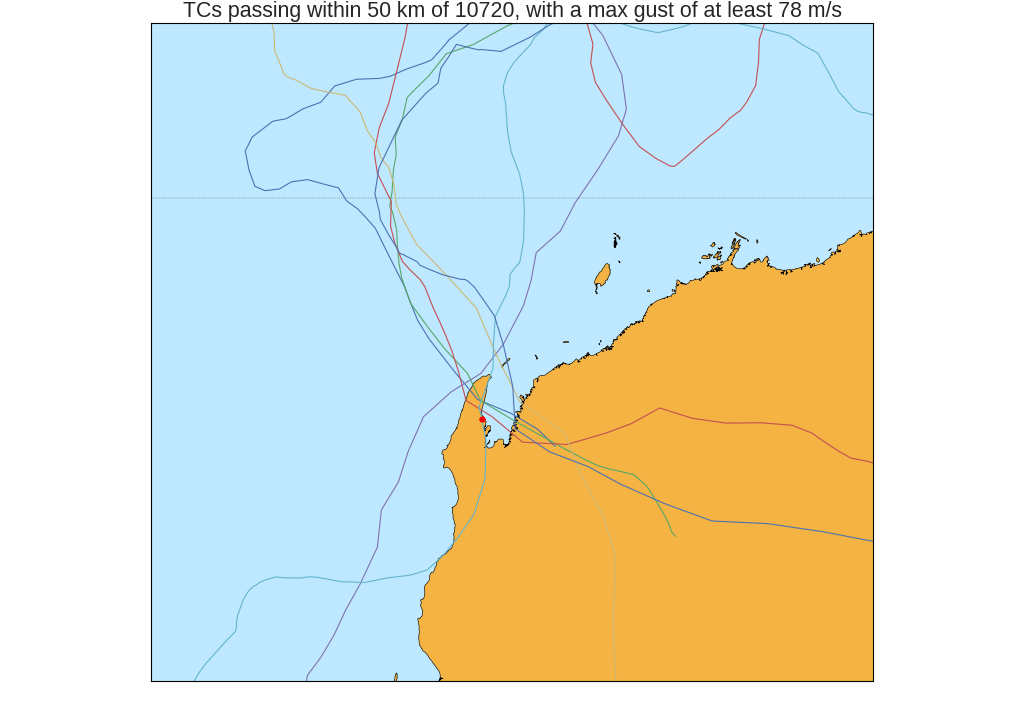

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [9]:
fig, axes = plt.subplots()
plot_relevant_tracks(name_list, speed_thr, dist_thr)

w = widgets.HTML("TC info for the selected track")
def onclick(event):
    w.value = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(event.button, 
                                                           event.x, event.y, event.xdata, event.ydata)
    w.event = event
    print(w.event.xdata, w.event.ydata)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## For now, we'll pretend the click selection is working... :(

In [20]:
event_chosen = extreme_events[5]
event_chosen

(u'Learmonth Airport', 90.77102661132812, -90.7198715209961, 3.046975612640381, u'008-00341', 0.4308960985834225, 101.24663543701172, 85337.875)

In [26]:
gust_filename = '/g/data/w85/cek156/db10kyr/windfield/gust.{0}.nc'.format(str(event_chosen['eventId']))
nc = Dataset(gust_filename)
lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]
rmax = nc.variables['rmax'][:]

IOError: No such file or directory